In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from datasist.structdata import detect_outliers



## other
#from imblearn.over_sampling import SMOTE

## sklearn -- preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

## sklearn -- models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

## skelarn -- metrics
from sklearn.metrics import f1_score, accuracy_score

### `Data URL`
- https://www.kaggle.com/code/touba7/insurance-prediction-with-five-regressor-models/data

### `Read Dataset`

In [4]:
df = pd.read_csv("insurance.csv", na_values=['Unknown', '', 'na', 'nan', 'NA', 'NAN' ])
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [185]:
df.shape

(103904, 25)

In [8]:
# trim and replace space inside columns names with _
df.columns = df.columns.str.lower().str.strip().str.strip().str.replace(' ', '_')
df.rename(columns={'sex':'gender'}, inplace=True)
df.head(3)

,age,gender,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


### `Check the datatypes of the columns`

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   gender    1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [10]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [11]:
df.describe(include=['O'])

,gender,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


### `Check number of NA cells in each column`

In [ ]:
# print the percentage of null cells in each column ordered desc 
df.isna().sum().sort_values(ascending=False) / df.shape[0]

age          0.0
gender       0.0
bmi          0.0
children     0.0
smoker       0.0
region       0.0
charges      0.0
age_group    0.0
dtype: float64

### `Feature Engineering`

#### `Create age_group contains the values (Infants, Children, Adolescents, Adults, Older)`

In [12]:
# age groups https://www.nih.gov/nih-style-guide/age#:~:text=Children%20(1%20year%20through%2012,Adults%20(18%20years%20or%20older)
# Neonates or newborns (birth to 1 month)
# Infants (1 month to 1 year)
# Children (1 year through 12 years)
# Adolescents (13 years through 17 years. They may also be referred to as teenagers depending on the context.)
# Adults (18 years or older)
# Older adults (65 and older)*

bins= [0,1,12,18,65,110]
labels = ['Infants','Children','Adolescents','Adults','Older']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False).astype(object)
df.loc[:,['age', 'age_group']]


,age,age_group
0,19,Adults
1,18,Adults
2,28,Adults
3,33,Adults
4,32,Adults
...,...,...
1333,50,Adults
1334,18,Adults
1335,18,Adults
1336,21,Adults


### `Visualization`

histogram bmi  given gender
histogram bmi  given age_group

countplot for smoker given gender
countplot for smoker given age_group

countplot of children given age_group

histogram of children given region
histogram of children given smoker

boxplot of bmi given region
boxplot of bmi given region and gender

scatterplot for changes given age and gender
boxplot of charges


##### `Draw histogram of Body mass index "bmi"  given gender`

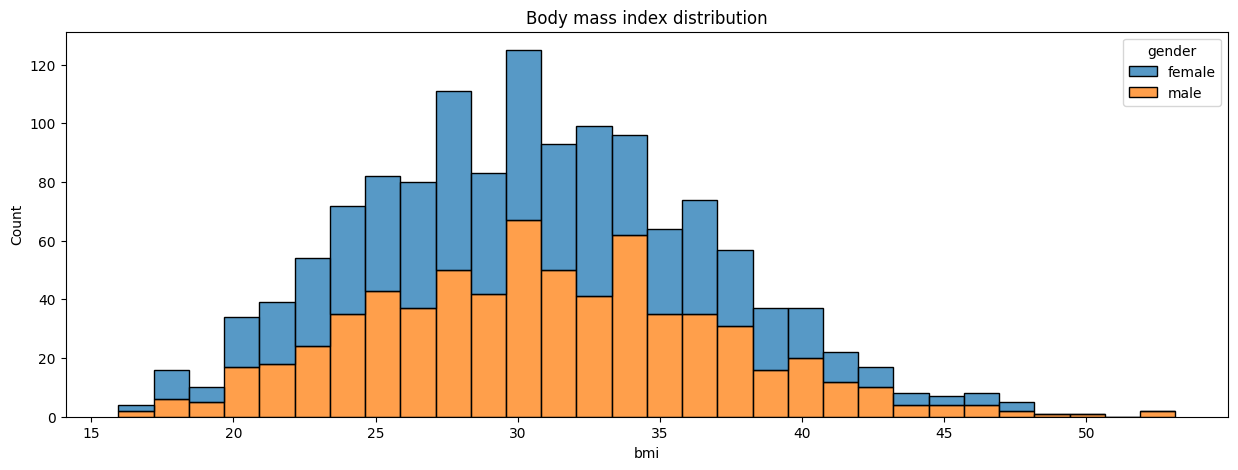

In [26]:
plt.figure(figsize=(15,5))
sns.histplot(data=df, x='bmi', hue='gender', bins=30, multiple='stack')
plt.title('Body mass index distribution')
plt.show()

##### `Display loyality of each gender`

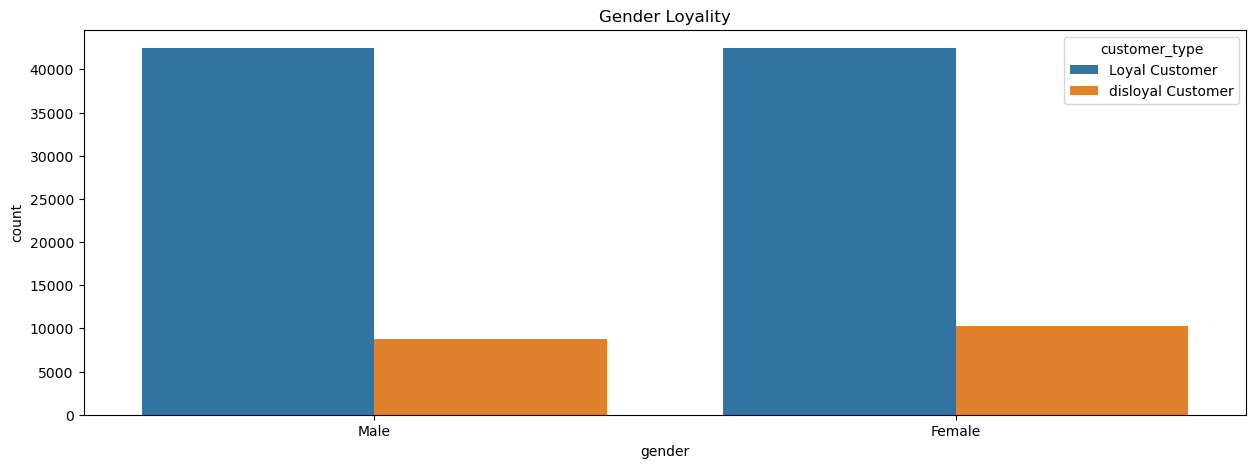

In [192]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='gender', hue='customer_type')
plt.title('Gender Loyality')
plt.show()

conclusion: 
- Loyality of genders are almost equal

##### `Display relation between flght_distance and class and type_of_travel`

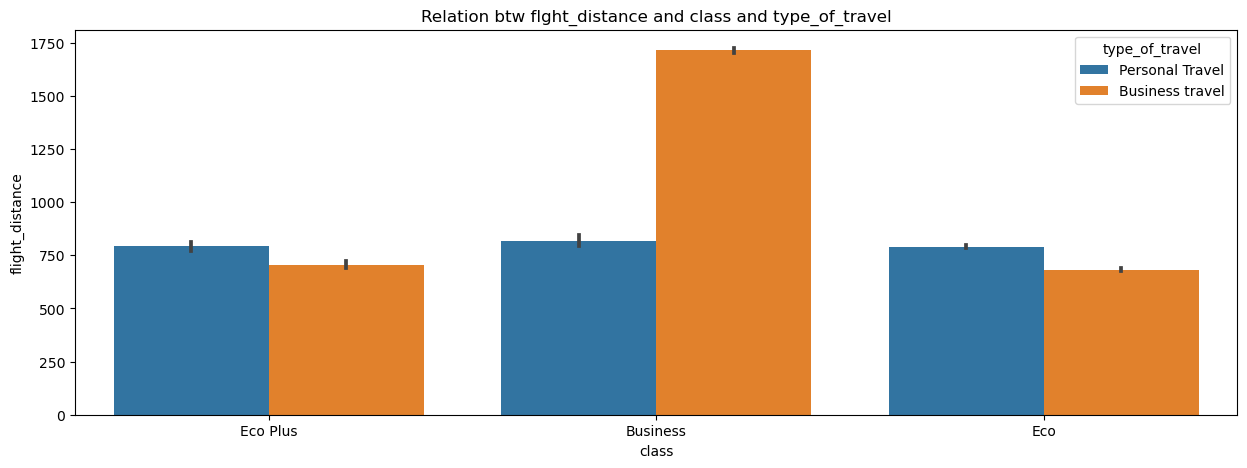

In [193]:
plt.figure(figsize=(15,5))
sns.barplot(data=df, y='flight_distance', x='class', hue='type_of_travel')
plt.title('Relation btw flght_distance and class and type_of_travel')
plt.show()

#### `Draw relationship between arrival_delay_in_minutes, flight_distance and satisfaction `

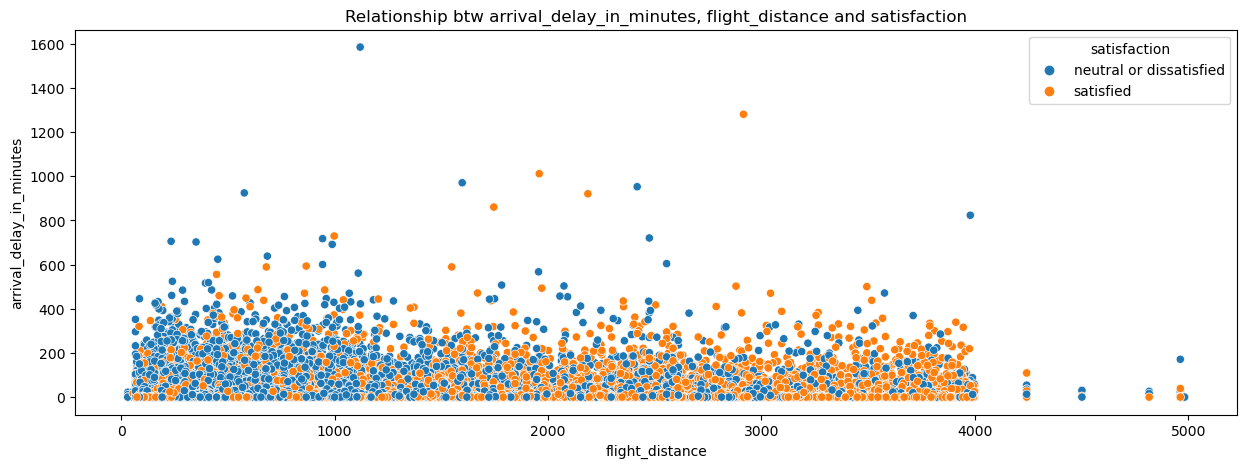

In [194]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=df, y='arrival_delay_in_minutes', x='flight_distance', hue='satisfaction')
plt.title('Relationship btw arrival_delay_in_minutes, flight_distance and satisfaction')
plt.show()

conclusion: 
- there is uniform distribution between flight_distance and arrival_delay_in_minutes
- People are more satisfied in long-distance flights

conclusion: 
- Business Class is used more in case of long-distance flights

#### `Draw relationship between age_group and gender `

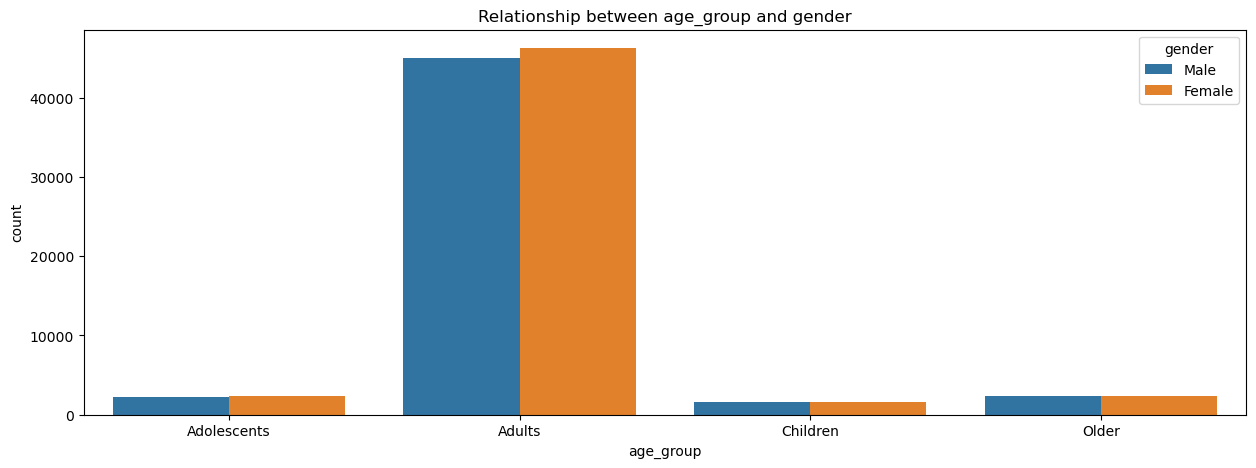

In [195]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='age_group', hue='gender')
plt.title('Relationship between age_group and gender')
plt.show()

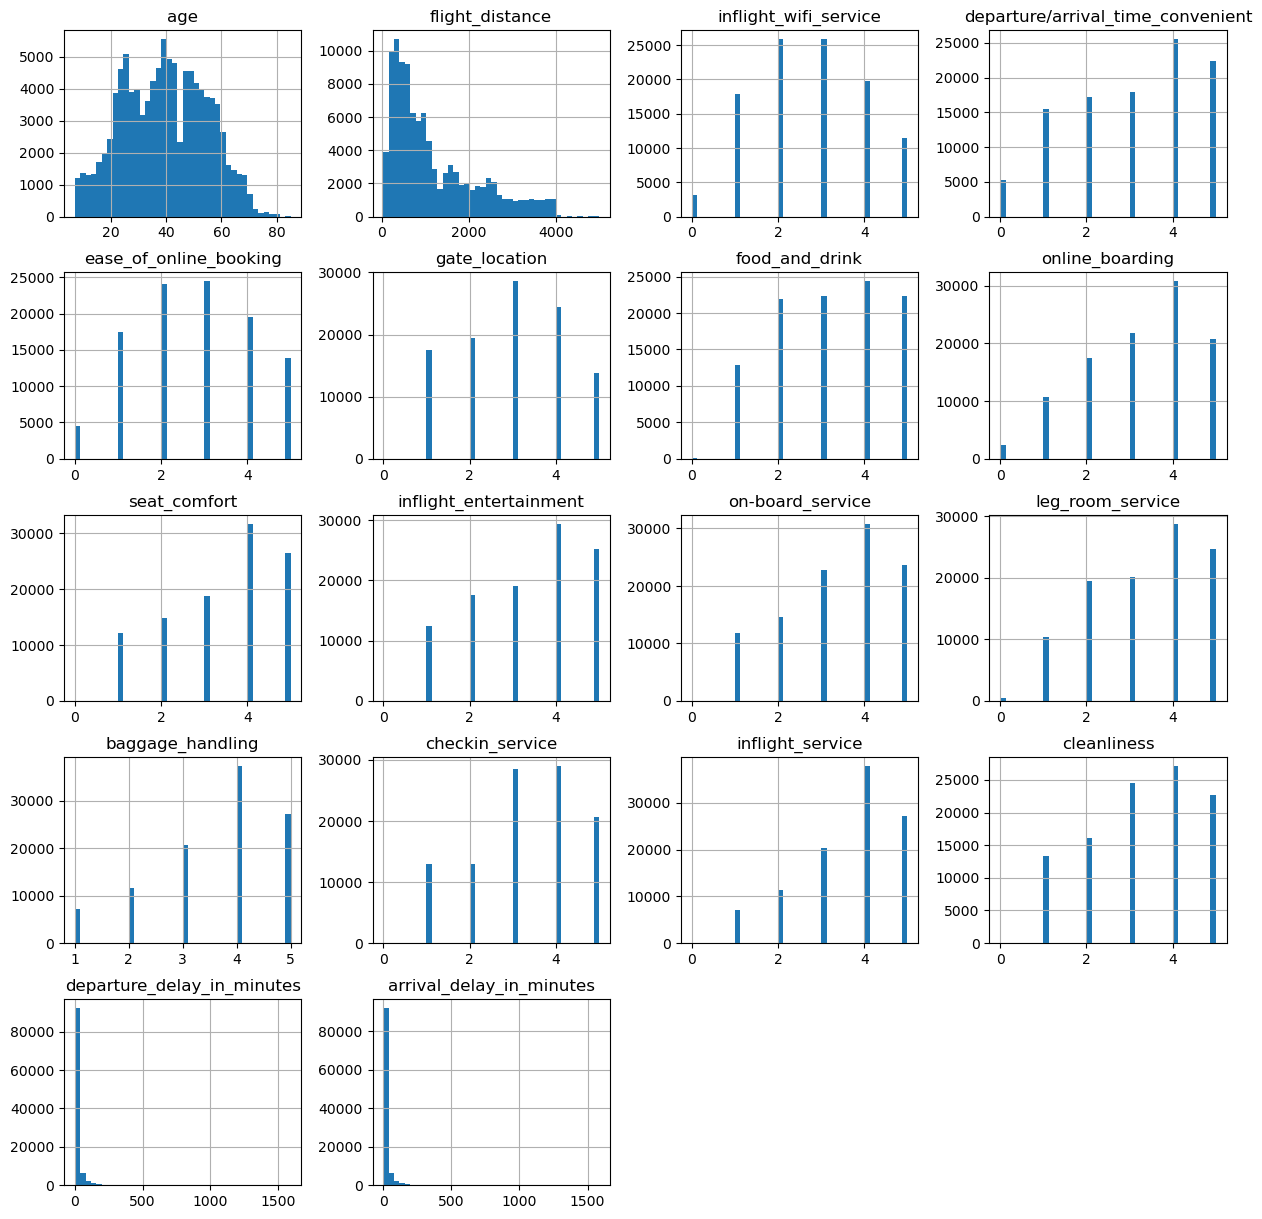

In [197]:
df.hist(bins=40, figsize=(15,15))
plt.show()

### `Detect Outliers and replace them with the median`

column  flight_distance
median  843.0
outliers_indices count  2291
--------------------
column  departure_delay_in_minutes
median  0.0
outliers_indices count  14529
--------------------
column  arrival_delay_in_minutes
median  0.0
outliers_indices count  0
--------------------


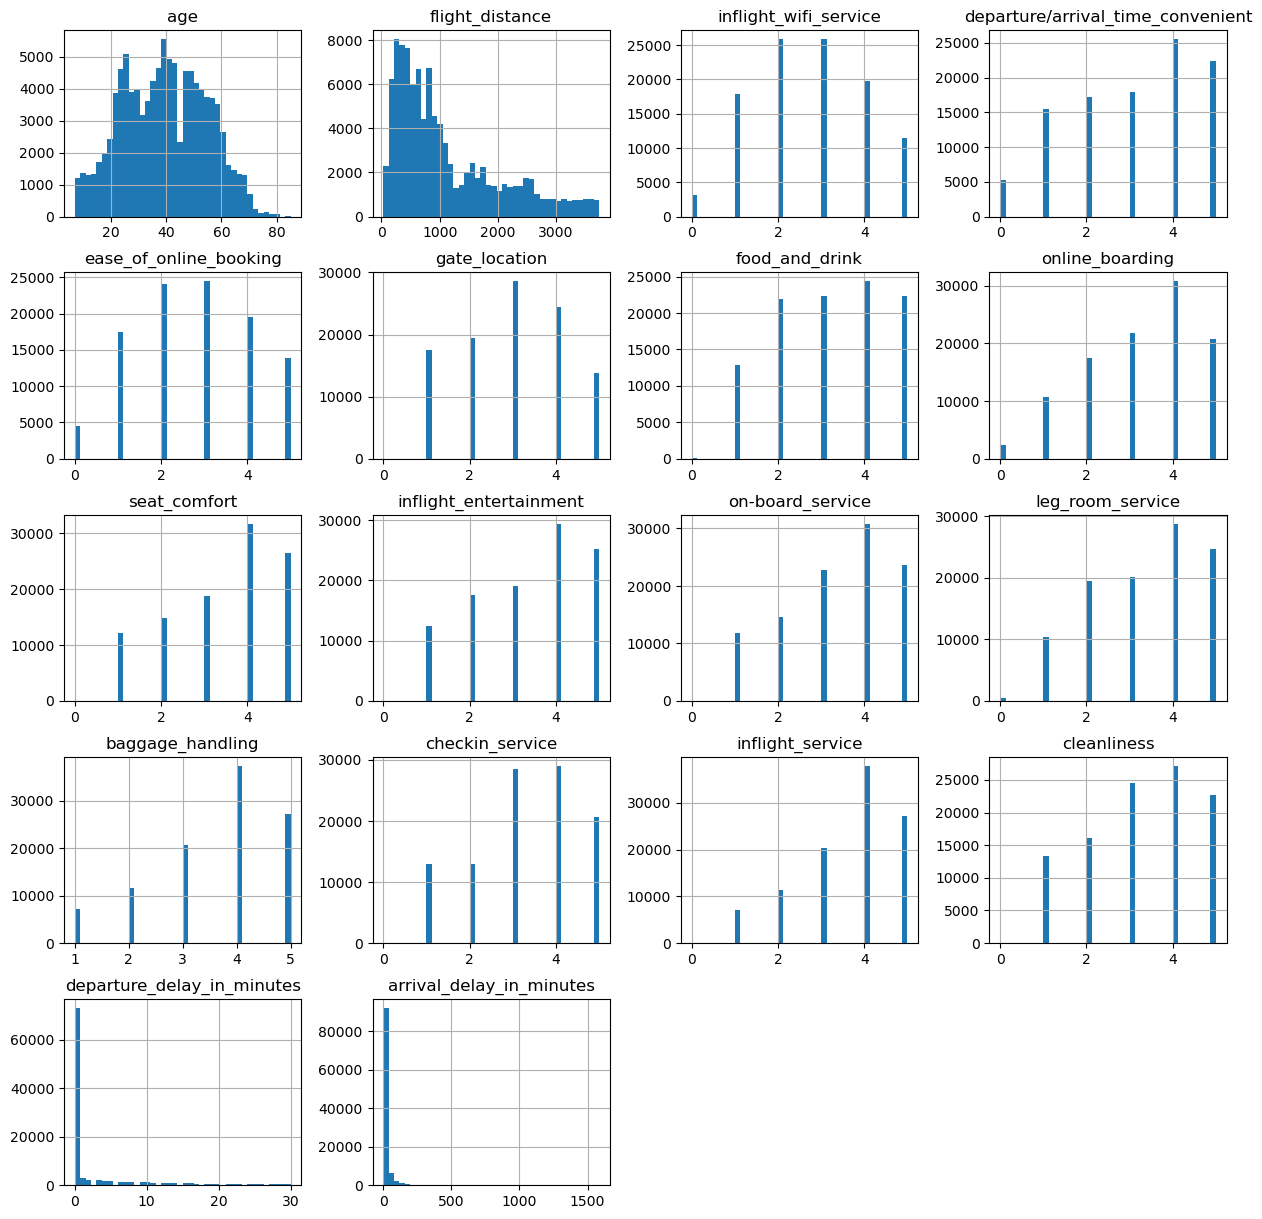

In [198]:
cols = np.array(['flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes'])

for col in cols: 
    outliers_indices = detect_outliers(df, 0, [col])
    
    col_median = df[col].median()
    print('column ', col)
    print('median ', col_median) 
    print('outliers_indices count ',len( outliers_indices))
    print('----'*5)
    df.loc[outliers_indices, col] = col_median

df.hist(bins=40, figsize=(15,15))
plt.show()

### `Diagram to show boxplot of the flight_distance and divided by gender`

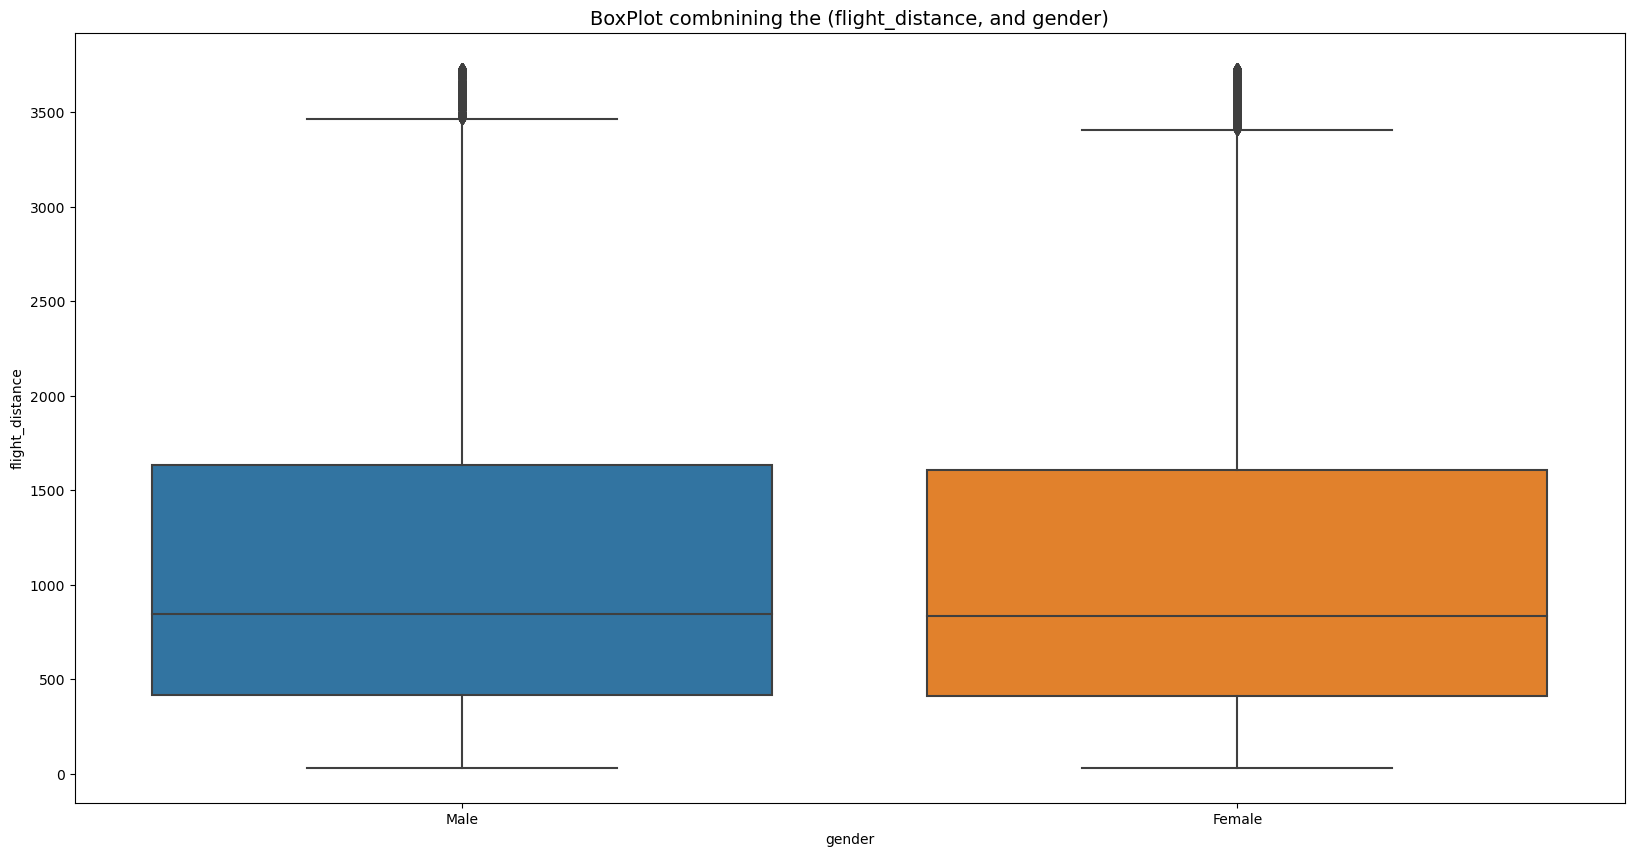

In [199]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df, y='flight_distance', x='gender' )
plt.title('BoxPlot combnining the (flight_distance, and gender)', fontsize=14, color='k')
plt.show()

### `Split Data into train and validation datasets`

In [200]:
## Features and target
X = df.drop(columns=['satisfaction'], axis=1)
y = df['satisfaction']

## to full train and test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=45, stratify=y)

print('X_train shape', X_train.shape)
print('X_valid shape', X_valid.shape)
print('y_train shape', y_train.shape)
print('y_valid shape', y_valid.shape)

X_train shape (83123, 23)
X_valid shape (20781, 23)
y_train shape (83123,)
y_valid shape (20781,)


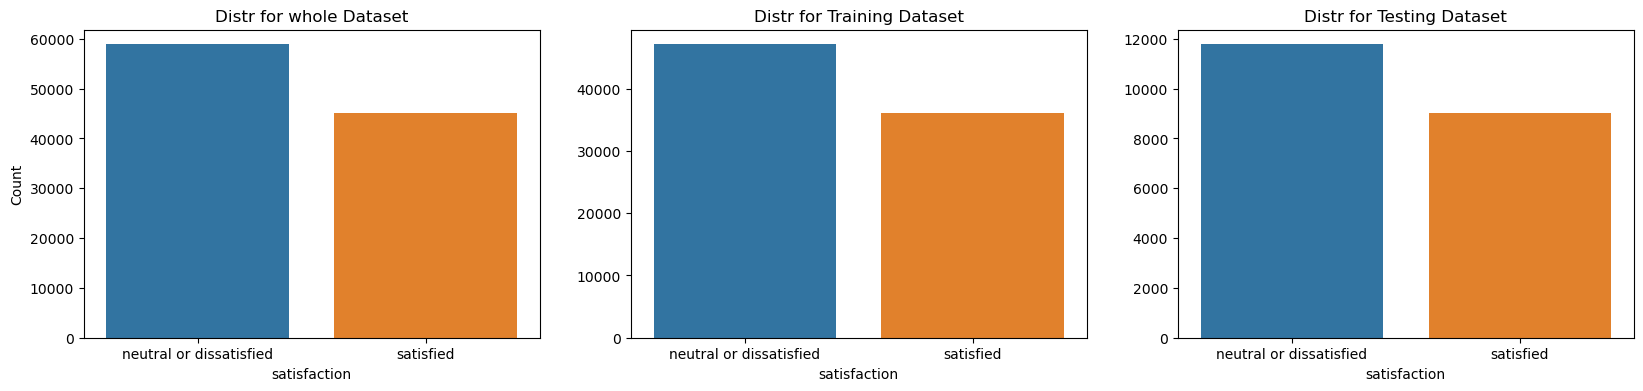

In [201]:
## Check the distr of target in train and test
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

## for full data
plt.sca(ax[0])
sns.countplot(x=y, order=y.value_counts().index.tolist())
plt.title('Distr for whole Dataset')
plt.ylabel('Count')

## for Training data
plt.sca(ax[1])
sns.countplot(x=y_train, order=y.value_counts().index.tolist())
plt.title('Distr for Training Dataset')
plt.ylabel('')


## for Testing  data
plt.sca(ax[2])
sns.countplot(x=y_valid, order=y.value_counts().index.tolist())
plt.title('Distr for Testing Dataset')
plt.ylabel('')
plt.show()

#### `Data Preprocessing`

In [202]:
## Slice cols
num_cols = ['age', 'flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']
categ_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()
print(categ_cols)
ready_cols = list(set(X_train.columns.tolist()) - set(num_cols) - set(categ_cols))
print(ready_cols)

['gender', 'customer_type', 'type_of_travel', 'class', 'age_group']
['online_boarding', 'on-board_service', 'departure/arrival_time_convenient', 'inflight_service', 'cleanliness', 'inflight_entertainment', 'leg_room_service', 'ease_of_online_booking', 'gate_location', 'seat_comfort', 'inflight_wifi_service', 'baggage_handling', 'checkin_service', 'food_and_drink']


In [203]:
## Pipeline 

## Numerical --> Impute using median, Standardization
## Cateforical --> Impute using mode, OHE
## Redy cols ---> Imputing

## Target ---> Label Encoding

In [204]:
## Numerical
num_pipline = Pipeline(steps=[
                ('selector', DataFrameSelector(num_cols)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])

## Categorical
categ_pipline = Pipeline(steps=[
                 ('selector', DataFrameSelector(categ_cols)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

## Ready cols -- Discret cols
ready_pipeline = Pipeline(steps=[
                ('selector', DataFrameSelector(ready_cols)),
                ('imputer', SimpleImputer(strategy='most_frequent'))
])


## Combine all
all_pipeline = FeatureUnion(transformer_list=[
                        ('num', num_pipline),
                        ('categ', categ_pipline),
                        ('ready', ready_pipeline)
                    ])

## apply
X_train_final  = all_pipeline.fit_transform(X_train)
X_valid_final = all_pipeline.transform(X_valid)


target__encoder = LabelEncoder()
y_train_encoded =  target__encoder.fit_transform(y_train)
y_valid_encoded =  target__encoder.transform(y_valid)

In [205]:
## Check shapes

print('X_train_final.shape \t', X_train_final.shape)
print('y_train_encoded.shape \t', y_train_encoded.shape)
print('**'*20)
print('X_valid_final.shape \t', X_valid_final.shape)
print('y_valid_encoded.shape \t', y_valid_encoded.shape)  ## fine

X_train_final.shape 	 (83123, 26)
y_train_encoded.shape 	 (83123,)
****************************************
X_valid_final.shape 	 (20781, 26)
y_valid_encoded.shape 	 (20781,)


#### `Building Models`

`Let's consider evaluation metric f1_score `

#### 1. Logistic Regression

In [206]:
## Using Logistic Reg 
log_clf = LogisticRegression(penalty=None, max_iter=10000, multi_class='auto')
log_clf.fit(X_train_final, y_train_encoded) 

## Predict and evaluate 
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_valid_final)

## Evaluate
score_train_log = f1_score(y_train_encoded, y_pred_train_log)
score_test_log = f1_score(y_valid_encoded, y_pred_test_log)

print(f'F1 Score for Training Dataset using Logisitic {score_train_log * 100 :.3f}')
print(f'F1 Score for Validation Dataset using Logisitic {score_test_log * 100 :.3f}')

F1 Score for Training Dataset using Logisitic 85.485
F1 Score for Validation Dataset using Logisitic 84.802


#### 2. Naive Bayes

In [207]:
## Gaussian NB OR Bernolii, Multinomail (Only positive dataset)
naive_clf = GaussianNB()
naive_clf.fit(X_train_final, y_train_encoded)  

# Predict and evaluate 
y_pred_train_naive = naive_clf.predict(X_train_final)
y_pred_test_naive = naive_clf.predict(X_valid_final)

## Evaluate
score_train_naive = f1_score(y_train_encoded, y_pred_train_naive)
score_test_naive = f1_score(y_valid_encoded, y_pred_test_naive)

print(f'F1 Score for Training Dataset using Gaissian NB {score_train_naive * 100 :.3f}')
print(f'F1 Score for Validation Dataset using Gaissian NB {score_test_naive * 100 :.3f}')

F1 Score for Training Dataset using Gaissian NB 82.368
F1 Score for Validation Dataset using Gaissian NB 81.974


#### 3. RandomForest

In [208]:
forst_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45)
forst_clf.fit(X_train_final, y_train_encoded)

## Predict and evaluate 
y_pred_train_forest = forst_clf.predict(X_train_final)
y_pred_test_forest = forst_clf.predict(X_valid_final)

## Evaluate
score_train_forest = f1_score(y_train_encoded, y_pred_train_forest)
score_test_forest = f1_score(y_valid_encoded, y_pred_test_forest)

print(f'F1 Score for Training Dataset using RF {score_train_forest * 100 :.3f}')
print(f'F1 Score for Validation Dataset using RF {score_test_forest * 100 :.3f}')

F1 Score for Training Dataset using RF 91.381
F1 Score for Validation Dataset using RF 90.775


4. KNN

In [209]:
## Using knn 
knn_clf = KNeighborsClassifier(n_neighbors=5, p=2, n_jobs=-1)
knn_clf.fit(X_train_final, y_train_encoded) 

## Predict and evaluate 
y_pred_train_knn = knn_clf.predict(X_train_final)
y_pred_test_knn = knn_clf.predict(X_valid_final)

## Evaluate
score_train_knn = f1_score(y_train_encoded, y_pred_train_knn)
score_test_knn = f1_score(y_valid_encoded, y_pred_test_knn)

print(f'F1 Score for Training Dataset using KNN {score_train_knn * 100 :.3f}')
print(f'F1 Score for Validation Dataset using KNN {score_test_knn * 100 :.3f}')

F1 Score for Training Dataset using KNN 93.917
F1 Score for Validation Dataset using KNN 90.844
